# Preparation

## Download datasets and libraries

In [31]:
%%capture
import os
if not os.path.exists('./ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

!pip install facenet-pytorch
!wget https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
!pip install imutils dlib wandb facenet-pytorch

## Import dependencies

In [1]:
import time
import os
import random
from math import *
from collections import OrderedDict
import requests
from tqdm import tqdm
from pathlib import Path
from io import StringIO, BytesIO

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
import imutils
from skimage import io, transform
from xml.etree import ElementTree
import dlib

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, IterableDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from facenet_pytorch import MTCNN

import wandb

from kaggle_secrets import UserSecretsClient
secret_label = "WandB"
secret_value = UserSecretsClient().get_secret(secret_label)
wandb.login(key=secret_value)

/home/aitor/miniconda3/envs/FaceLandmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'wandb'

## Configuration
In this section, all the necessary parameters are defined to load the data and train the model

In [2]:
class Config(dict):
    @classmethod
    def __new__(cls, *args, **kwargs):
        self = super(Config, cls).__new__(*args, **kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
        return self


In [3]:
CONFIG = Config(
  base=Config(
    seed=42,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  ),
  dataset=Config(
    size=(224, 224),
    train=Config(
        folder="./ibug_300W_large_face_landmark_dataset",
        path="labels_ibug_300W_train.xml"
    ),
    test=Config(
        url="https://thispersondoesnotexist.com/",
        shape_predictor_path="./shape_predictor_68_face_landmarks.dat"
    )

  ),
  training=Config(
      epochs=1,
      batch_size=16,
      learning_rate=0.0001,
      stepLR_size=100,
      gamma=0.1
  ),
  sweep_config=Config(
      method="bayes",
      metric=Config(
          name="eval/loss",
          goal="minimize"
      ),
      parameters=Config(
          learning_rate=Config(
              distribution="uniform",
              min=0.00001,
              max=0.001
          ),
          batch_size=Config(
              values=[8, 16, 32]
          ),
          epochs=Config(
            distribution="int_uniform",
              min=1,
              max=10
          ),
          stepLR_size=Config(
              distribution="int_uniform",
              min=10, 
              max=1000
          ),
          gamma=Config(
              distribution="uniform",
              min=0.01,
              max=0.9
          )
        )
  )
)

## Auxiliar functions

In [4]:
def set_seed(seed=42):
    import numpy as np
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def draw_rectangle_and_points(image: Image.Image, landmarks: list[torch.Tensor], boxes=None, color="blue", fill=(0, 0, 255, 25)):
    no_boxes = False
    if boxes is None:
        boxes = [[-1, -1, -1, -1] for _ in range(len(landmarks))]
        no_boxes = True

    # Create a copy of the original image
    img_with_elements = image.copy()

    # Create an ImageDraw object to draw on the image
    draw = ImageDraw.Draw(img_with_elements)

    for box, landmark in zip(boxes, landmarks):
        if not no_boxes:
            # Coordinates of the box
            x1, y1, x2, y2 = box

            # Draw the rectangle
            draw.polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)], outline=color, fill=fill)

        # Draw the landmarks
        for point in landmark:
            x, y = point
            radius = 2
            draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=color)

    return img_with_elements

def load_image_opencv_from_local(path):
    # Read the image from a local file
    image = cv2.imread(path)

    if image is not None:
        return image
    else:
        print("Could not open the image in", path)

def load_image_opencv_from(url):
    response = requests.get(url)

    if response.status_code == 200:
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)

        image_cv2 = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        return image_cv2
    else:
        print("Could not load the image:", response.status_code)

def convert_opencv_to_pillow(image_cv2):
    if len(image_cv2.shape) == 3:
        if image_cv2.shape[2] == 1:
            image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_GRAY2RGB)
        elif image_cv2.shape[2] == 4:
            image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGRA2RGBA)
        else:
            image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    elif len(image_cv2.shape) == 2:
        image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_GRAY2RGB)

    image_pillow = Image.fromarray(image_cv2)

    return image_pillow

def visualize(image, landmarks, boxes=None):
    no_boxes = False
    if boxes is None:
        boxes = [[-1, -1, -1, -1] for _ in range(len(landmarks))]
        no_boxes = True

    height, width = image.size
    rel = height / width

    fig, ax = plt.subplots(figsize=(6, 6*rel))

    ax.imshow(image)
    ax.axis('off')

    for box, landmark in zip(boxes, landmarks):
        # Draw rectangle
        if not no_boxes:
            rect = Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=0, edgecolor='none', facecolor='blue', alpha=0.1)
            ax.add_patch(rect)

        ax.scatter(landmark[:, 0], landmark[:, 1], s=15, color="red")

    plt.show()


set_seed(CONFIG.base.seed)

# Datasets and DataLoaders

## Datasets

1. "FaceLandmarkDatasetTest", this dataset will be used for the testing.

2. "FaceLandmarkDataset", this dataset is used for training and validation. It reads images from the dataset ibug_300W_large_face_landmark_dataset. It can be changed in the CONFIG to train with other dataset.

In [5]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        tree = ElementTree.parse(Path(CONFIG.dataset.train.folder)/CONFIG.dataset.train.path)
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.normalizer = Normalize(CONFIG.dataset.size)
        self.root_dir = CONFIG.dataset.train.folder

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image_pil = convert_opencv_to_pillow(load_image_opencv_from_local(self.image_filenames[index]))
        image_data = np.asarray(image_pil)
        landmarks = self.landmarks[index]

        if self.transform:
            image_data, landmarks = self.transform(image_data, landmarks, self.crops[index])



        # Normalize
        image_pt, landmarks = self.normalizer(image_data, landmarks)

        # Get class of each pixel
        _, landmark_denorm = self.normalizer.denormalize(image_pt, landmarks)
        annotations = torch.zeros(69, CONFIG.dataset.size[1], CONFIG.dataset.size[0])
        annotations[0, :, :] = 1

        for i in range(landmark_denorm.shape[0]):
          # If landmark is inside picture, mark its pixel with corresponding class
          if landmark_denorm[i][1] < CONFIG.dataset.size[1] and\
            landmark_denorm[i][0] < CONFIG.dataset.size[0]:
            j = int(landmark_denorm[i][1])
            k = int(landmark_denorm[i][0])

            annotations[0, j, k] = 0
            annotations[i + 1, j, k] = 1


        return image_pt, landmarks, annotations


class FaceLandmarksDatasetTest(IterableDataset):
    def __init__(self, transform=None, max_items=1000):
        self.device = "cpu"
        self.max_items = max_items
        self.url = CONFIG.dataset.test.url

        self.mtcnn = MTCNN(select_largest=False, post_process=False, keep_all=True, device=self.device)

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(CONFIG.dataset.test.shape_predictor_path)
        self.transform = transform
        self.normalizer = Normalize(CONFIG.dataset.size)

    def __len__(self):
        return self.max_items


    def __iter__(self):
        for _ in range(self.max_items):
            image = convert_opencv_to_pillow(load_image_opencv_from(self.url))

            boxes, probs = self.mtcnn.detect(image, landmarks=False)
            for bface in boxes:
                left, top, right, bottom = int(bface[0]), int(bface[1]), int(bface[2]), int(bface[3])
                # Crop the region of interest (ROI) of the original image
                roi = np.asarray(image)[top:bottom, left:right]
                gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                faces = self.detector(gray)

                if faces:
                    face = faces[0]
                    # Detect landmarks if a face has been detected
                    landmarks_obj = self.predictor(gray, face)

                    # Create a list of landmarks
                    landmark_points = []
                    for n in range(0, 68):
                        landmark_points.append([landmarks_obj.part(n).x, landmarks_obj.part(n).y])

                    image_data = roi
                    landmarks = torch.Tensor(landmark_points)
                    if self.transform:
                        image_data, landmarks = self.transform(image_data, landmarks, with_face_crop=False, with_rotation=False)

                    # Normalize
                    image_pt, landmarks = self.normalizer(image_data, landmarks)


                    # Get class of each pixel
                    _, landmark_denorm = self.normalizer.denormalize(image_pt, landmarks)
                    annotations = torch.zeros(69, CONFIG.dataset.size[1], CONFIG.dataset.size[0])
                    annotations[0, :, :] = 1

                    for i in range(landmark_denorm.shape[0]):
                      # If landmark is inside picture, mark its pixel with corresponding class
                      if landmark_denorm[i][1] < CONFIG.dataset.size[1] and\
                        landmark_denorm[i][0] < CONFIG.dataset.size[0]:
                        j = int(landmark_denorm[i][1])
                        k = int(landmark_denorm[i][0])
            
                        annotations[0, j, k] = 0
                        annotations[i + 1, j, k] = 1


                    yield image_pt, landmarks, annotations

class Normalize():
    def __init__(self, image_size):
        self.image_size = image_size

    def resize_n_crop(self, image: Image.Image, landmarks=None) -> tuple[Image.Image, torch.Tensor]:
        # Get the original dimensions of the image
        original_width, original_height = image.size

        # Compute the scale factor to resize the image keeping the aspect ratio
        aspect_ratio = original_width / original_height
        target_width, target_height = self.image_size
        if original_width > original_height:
            scale_factor = target_width / original_width
        else:
            scale_factor = target_height / original_height

        # Resize the image
        image = TF.resize(image, (int(original_height * scale_factor), int(original_width * scale_factor)))

        # Resize the landmarks
        if landmarks is not None:
            landmarks = landmarks * scale_factor

        # If the resized image does not have the same dimensions as img_size, crop or amplify it
        new_width, new_height = image.size
        left = (new_width - target_width) / 2
        top = (new_height - target_height) / 2
        right = (new_width + target_width) / 2
        bottom = (new_height + target_height) / 2

        # Adjust the landmark coordinates
        if landmarks is not None:
            if target_width > new_width:
                landmarks[:, 0] = landmarks[:, 0] - (new_width - target_width)/2
            if target_height > new_height:
                landmarks[:, 1] = landmarks[:, 1] - (new_height - target_height)/2

        image = image.crop((left, top, right, bottom))

        return image, landmarks

    def __call__(self, image_data: np.array, landmarks=None):
        image = Image.fromarray(image_data)
        image, landmarks = self.resize_n_crop(image, landmarks)
        image_data = np.asarray(image).astype('float32')
        image_pt = torch.from_numpy(image_data).squeeze()

        if len(image_pt.shape) == 2:
            image_pt = image_pt.reshape([1, *image_pt.shape])

        image_pt = TF.normalize(image_pt, [0.5], [0.5])
        if landmarks is not None:
            landmarks = landmarks / self.image_size[0]
            landmarks = landmarks - 0.5

        return image_pt, landmarks

    def denormalize(self, image_pt: torch.Tensor, landmarks=None):
        # Denormalize the image
        image_pt = image_pt * 0.5 + 0.5

        # Denormalize the landmarks
        if landmarks is not None:
            landmarks = landmarks + 0.5
            landmarks = landmarks * self.image_size[0]

        return image_pt.to(torch.uint8), landmarks


class Transforms():
    def rotate(self, image: Image.Image, landmarks=None, angle=10) -> tuple[Image.Image, torch.Tensor]:
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = Image.fromarray(imutils.rotate(np.asarray(image), angle))

        if landmarks is not None:
            im_width, im_height = image.size
            landmarks = landmarks - torch.from_numpy(np.array([im_width/2, im_height/2]))
            landmarks = np.matmul(landmarks, transformation_matrix)
            landmarks = landmarks + torch.from_numpy(np.array([im_width/2, im_height/2]))

        return image, landmarks

    def color_jitter(self, image: Image):
        color_jitter = transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.1
        )
        image = color_jitter(image)
        return image

    @staticmethod
    def crop_face(image: Image.Image, landmarks=None, crops: dict[str, int]=None) -> tuple[np.array, torch.Tensor]:
        if landmarks is None and crops is None:
            return image, None

        if landmarks is not None:
            left_land = float(landmarks[:,0].min())
            top_land = float(landmarks[:,1].min())
            width_land = float(landmarks[:,0].max()) - left_land
            height_land = float(landmarks[:,1].max()) - top_land

        if crops is not None:
            left = int(crops['left'])
            top = int(crops['top'])
            width = int(crops['width'])
            height = int(crops['height'])
        else:
            left = left_land
            top = top_land
            width = 0
            height = 0

        if landmarks is not None:
            left = min(left, left_land)
            top = min(top, top_land)
            width = max(width, width_land)
            height = max(height, height_land)

        image = TF.crop(image, top, left, height, width)

        if landmarks is not None:
            img_shape = np.array(image).shape
            landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])

        return image, landmarks

    def __call__(self, image_np: np.array, landmarks=None, crops=None, with_face_crop=True, with_rotation=True) -> tuple[np.array, torch.Tensor]:
        image = Image.fromarray(image_np)
        if with_face_crop:
            image, landmarks = self.crop_face(image, landmarks, crops)
        if with_rotation:
            image, landmarks = self.rotate(image, landmarks, angle=20)
        image = self.color_jitter(image)

        gray = np.asarray(image.convert('L'))

        return gray, landmarks

In [38]:
transform = Transforms()
dataset = FaceLandmarksDataset(transform=transform)
no_trf_dataset = FaceLandmarksDataset()
test_dataset = FaceLandmarksDatasetTest(transform=transform)

In [39]:
valid_ds_size = int(0.3*len(dataset))
train_ds_size = len(dataset) - valid_ds_size

train_dataset, valid_dataset = random_split(dataset , [train_ds_size, valid_ds_size])

print(f"The length of the train dataset is {len(train_dataset)}")
print(f"The length of the validation dataset is {len(valid_dataset)}")
print(f"The length of the test dataset is {len(test_dataset)}")

The length of the train dataset is 4667
The length of the validation dataset is 1999
The length of the test dataset is 1000


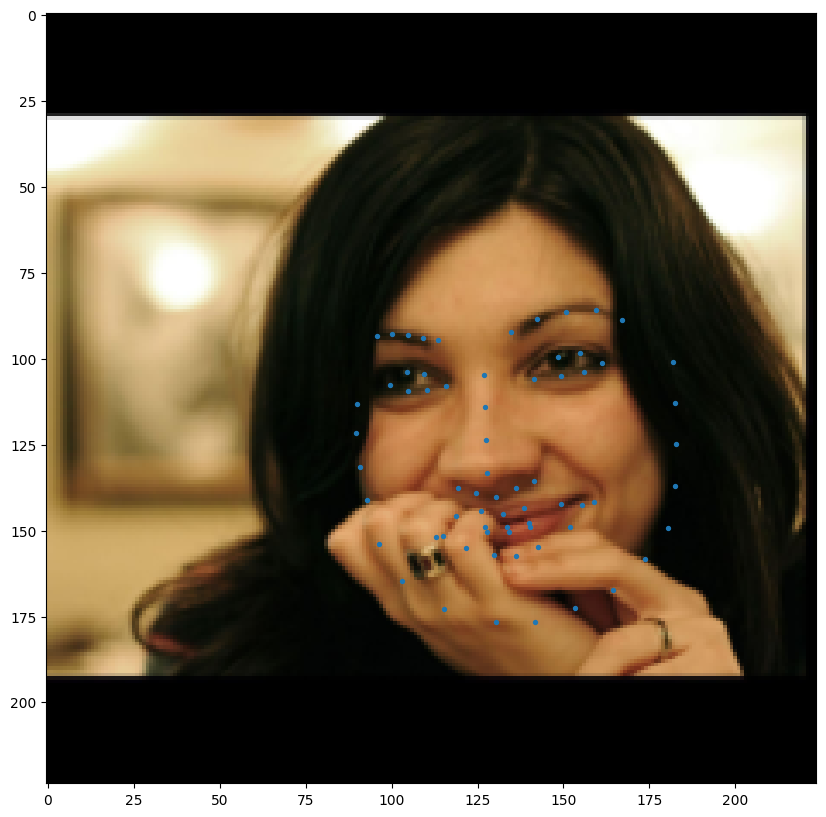

In [40]:
# Show an example of the FaceLandmarksDataset without transforms
image, landmarks, annotation = no_trf_dataset[673]
annot_flat = annotation.reshape(annotation.shape[0], -1)
image, landmarks = no_trf_dataset.normalizer.denormalize(image, landmarks)
plt.figure(figsize=(10, 10))
if len(image.shape) == 2:
    plt.imshow(image.numpy().squeeze(), cmap='gray')
else:
    plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=8)

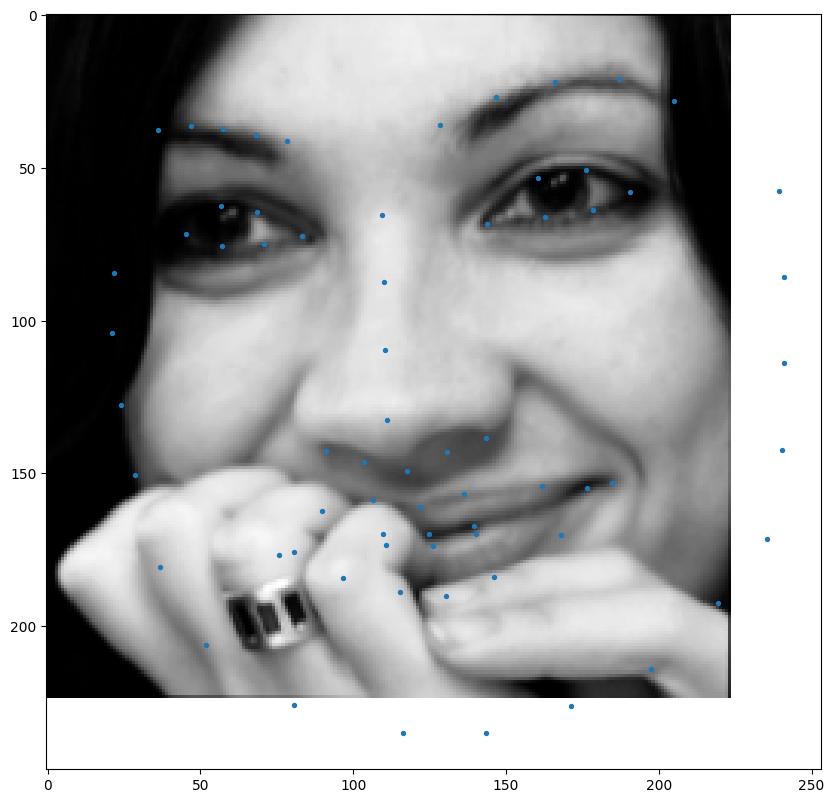

In [41]:
# Show an example of FaceLandmarksDataset with transforms
image, landmarks, _ = dataset[673]
image_, landmarks_ = dataset.normalizer.denormalize(image, landmarks)
plt.figure(figsize=(10, 10))
if len(image_.numpy().squeeze().shape) == 2:
    plt.imshow(image_.numpy().squeeze(), cmap='gray')
else:
    plt.imshow(image_)

plt.scatter(landmarks_[:,0], landmarks_[:,1], s=8)

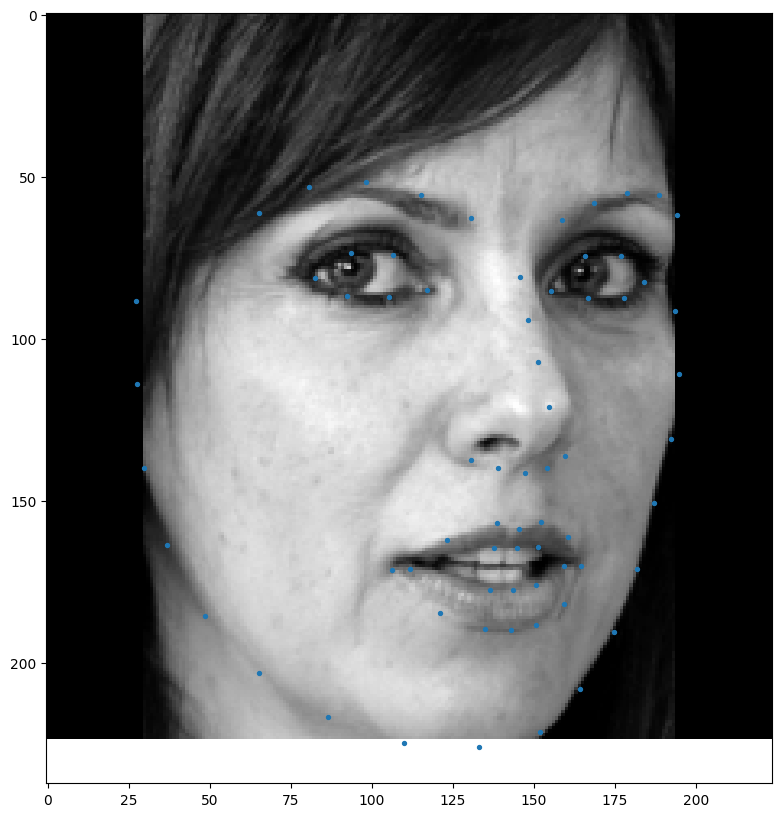

In [42]:
# Show an example of FaceLandmarksDatasetTest
for image, landmarks, _ in test_dataset:
    image_, landmarks_= test_dataset.normalizer.denormalize(image, landmarks)
    plt.figure(figsize=(10, 10))
    if len(image_.numpy().squeeze().shape) == 2:
        plt.imshow(image_.numpy().squeeze(), cmap='gray')
    else:
        plt.imshow(image_)

    plt.scatter(landmarks_[:,0], landmarks_[:,1], s=8)
    break

## DataLoaders

In [43]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CONFIG.training.batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=1)

# Model

The model is taken from https://github.com/chihfanhsu/fl_detection, changing their Tensor Flow implementation to PyTorch

In [6]:
class conv_blk(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(conv_blk, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride = (1, 1), padding = 'same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, input):
    return self.model(input)


class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1_1 = conv_blk(1, 64, (3, 3))
        self.c1_2 = conv_blk(64, 64, (3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.c2_1 = conv_blk(64, 128, (3, 3))
        self.c2_2 = conv_blk(128, 128, (3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.c3_1 = conv_blk(128, 256, (3, 3))
        self.c3_2 = conv_blk(256, 256, (3, 3))

        self.c3_3 = conv_blk(256, 256, (3, 3))
        self.c3_4 = conv_blk(256, 256, (3, 3))

        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.c4_1 = conv_blk(256, 512, (3, 3))
        self.c4_2 = conv_blk(512, 512, (3, 3))
        self.c4_3 = conv_blk(512, 512, (3, 3))
        self.c4_4 = conv_blk(512, 512, (3, 3))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.c5_1 = conv_blk(512, 512, (3, 3))
        self.c5_2 = conv_blk(512, 512, (3, 3))
        self.c5_3 = conv_blk(512, 512, (3, 3))
        self.c5_4 = conv_blk(512, 512, (3, 3))
        self.pool5 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # conv layer
        self.c6_1 = conv_blk(512, 2048, (7, 7))
        self.c6_2 = conv_blk(2048, 2048, (1, 1))

        self.conv8=nn.Conv2d(2048, 69, (1,1), stride=1,padding=0)

        self.conv_t1 = nn.ConvTranspose2d(69,
                                          512,
                                          (4, 4),
                                          stride=2,
                                          padding=1)
        self.conv_t2 = nn.ConvTranspose2d(512, 256,
                                          (4, 4),
                                          stride=2,
                                          padding=1)
        self.fuse_3 = nn.ConvTranspose2d(256, 69,
                                          (16, 16),
                                          stride=8,
                                          padding=4)
        self.hmap = nn.Softmax(dim = -2)


    def soft_argmax_2d(self, heatmap, height, width):

        # Create a grid of coordinates
        x_coords = torch.arange(0, width, dtype=torch.float32, device=heatmap.device)
        y_coords = torch.arange(0, height, dtype=torch.float32, device=heatmap.device)
        grid_x, grid_y = torch.meshgrid(x_coords, y_coords)

        # Compute weighted average of coordinates
        x_coords = torch.sum(heatmap * grid_x.flatten(), dim=-1)
        y_coords = torch.sum(heatmap * grid_y.flatten(), dim=-1)

        # Normalise computed coordinates
        x_coords = x_coords / width - 0.5
        y_coords = y_coords / height - 0.5

        # Stack x and y coordinates
        coordinates = torch.stack((x_coords, y_coords), dim=-1)

        # Split background and prediction points
        back_ground, pred_pts = torch.split(coordinates, [1, 68], dim=1)

        return pred_pts

    def heatmap2pts(self, hm, height, width):
      """
      Convert a heatmap tensor to 2D point coordinates.

      Args:
          hm (torch.Tensor): Input heatmap tensor of shape (batch_size, channels, height * width)

      Returns:
          torch.Tensor: Predicted points tensor of shape (batch_size, 68, 2)
      """
      assert len(hm.shape) == 3


      # Get argmax of the flattened tensor
      argmax = hm.argmax(dim=2)

      # Convert indexes into 2D coordinates
      argmax_y = (argmax // width).to(torch.float32)
      argmax_x = (argmax % width).to(torch.float32)

      # Stack x and y coordinates
      all_pts = torch.stack((argmax_x, argmax_y), dim=2)

      # Split background and prediction points
      back_ground, pred_pts = torch.split(all_pts, [1, 68], dim=1)
      #print(pred_pts.shape)
      return pred_pts

    def forward(self, x):
      for layer in [self.c1_1, self.c1_2, self.pool1,
                    self.c2_1, self.c2_2, self.pool2,
                    self.c3_1, self.c3_2, self.c3_3, self.c3_4, self.pool3]:
        x = layer(x)

      pool3 = x.clone()

      for layer in [self.c4_1, self.c4_2, self.c4_3, self.c4_4, self.pool4]:
        x = layer(x)

      pool4 = x.clone()

      for i,layer in zip(range(20),[self.c5_1, self.c5_2, self.c5_3, self.c5_4, self.pool5,
                    self.c6_1, self.c6_2, self.conv8, self.conv_t1]):
        x = layer(x)

      x = x + pool4
      x = self.conv_t2(x)
      x = x + pool3
      x = self.fuse_3(x)
      fuse_3 = x.clone()

      annotation_pred = x.argmax(axis = 1)

      height = x.shape[2]
      width = x.shape[3]
      x = x.reshape(x.shape[0], x.shape[1], -1)

      x = self.hmap(x)

      hmap = x.clone()

      pts = self.soft_argmax_2d(x, height, width)

      return torch.unsqueeze(annotation_pred, dim=3), fuse_3, hmap, pts


def pts2map(pts, heatmap_size):
    """
    Transforms point coordinates into a heatmap representation.

    Args:
        pts (torch.Tensor): Point coordinates of shape (num_points, 2).
        heatmap_size (tuple): Desired size of the heatmap (height, width).

    Returns:
        torch.Tensor: Heatmap representation of the points.
    """

    # Create an empty heatmap
    heatmap = torch.zeros(heatmap_size)

    # Iterate through points and update heatmap
    for pt in pts:
        x, y = pt.int()  # Convert point coordinates to integers
        if 0 <= x < heatmap_size[1] and 0 <= y < heatmap_size[0]:
            heatmap[y, x] = 1  # Assign value 1 at the point location

    return heatmap

def loss_func(logits, heat_map, pred_pts, y_, annotation):
  # heatmap loss
  # Note: PyTorch expects class indices as a 1D tensor for cross entropy
  annotation_squeezed = annotation.reshape(annotation.shape[0],
                                           annotation.shape[1], -1)


  heatmap_loss = torch.nn.functional.cross_entropy(
      heat_map,
      annotation_squeezed,
      reduction='mean'
  )

  # reg loss - Euclidean distance between predicted and ground truth points
  reg_losses = torch.mean(torch.mean(torch.sqrt(torch.sum((y_ - pred_pts)**2, dim=-1)), dim=-1))

  # total loss
  tot_loss = heatmap_loss + 0.25 * reg_losses

  return tot_loss






# Trainig / Validation

In [45]:


def train_epoch(model, dataloader, criterion, optimizer, device, scheduler, evaluate_interval=50, **kwargs):
  model.train()
  for batch, (Image, Landmarks, Annotations) in enumerate(dataloader):
    Image, Landmarks, Annotations = Image.to(device), Landmarks.to(device), Annotations.to(device)
    _,logits,heat_map,pred_pts= model(Image)
    loss = criterion(logits, heat_map, pred_pts, Landmarks, Annotations)

    # Backpropagation.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    scheduler.step()


    if batch % evaluate_interval == 0:
        wandb.log({"train/loss": loss})
        wandb.log({"train/progress": (batch + 1) / len(dataloader)})
    
def evaluate_epoch(model, dataloader, criterion, device, epoch, obs_wandb=False, **kwargs):
  num_batches = len(dataloader)
  model.eval()
  eval_loss = 0
  with torch.no_grad():
      for (Image, Landmarks, Annotations) in dataloader:
          Image, Landmarks, Annotations = Image.to(device), Landmarks.to(device), Annotations.to(device)
          _,logits,heat_map,pred_pts= model(Image)
          loss = criterion(logits, heat_map, pred_pts, Landmarks, Annotations)
          eval_loss += loss

  eval_loss /= num_batches

  print(f"Avg loss: {eval_loss:2f} \n")
  wandb.log({"eval/loss": eval_loss})


In [46]:
class Trainer:
    def __init__(self, name, train_epoch_fn, evaluate_epoch_fn, wandb_secret=None):
      self.name = name
      self.train_epoch_fn = train_epoch_fn
      self.evaluate_epoch = evaluate_epoch_fn
      self.wandb_secret = wandb_secret

    def train(self, model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, scheduler, **kwargs):
      model.to(device)
      for i in range(num_epochs):
        print(f"Epoch: {i}")
        self.train_epoch_fn(model, train_dataloader, criterion, optimizer, device, scheduler, evaluate_interval=50)
        self.evaluate_epoch(model, val_dataloader, criterion, device, i, obs_wandb=False)



## Training

### Option 1: Use the parameters of the configuration for training

In [47]:
wandb.init(config=CONFIG.training, project="Face_Landmark_detector_1")
config=wandb.config

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2)

my_model = MyModel()
criterion = loss_func
optimizer = optim.Adam(my_model.parameters(), config.learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.stepLR_size, gamma=config.gamma)

my_trainer = Trainer("face_landmarks_detector-v1", train_epoch, evaluate_epoch)
print(os.path.join(wandb.run.dir, "my_model_" + str(config.batch_size) + "_" + str(config.learning_rate)))

try:
    my_trainer.train(my_model, train_loader, valid_loader, criterion, optimizer, CONFIG.training.epochs, CONFIG.base.device, scheduler)
finally:
    torch.save(my_model.state_dict(), os.path.join(wandb.run.dir, "my_model_" + str(config.batch_size) + "_" + str(config.learning_rate)))
    wandb.save(os.path.join(wandb.run.dir, "my_model_" + str(config.batch_size) + "_" + str(config.learning_rate)))
wandb.finish()

KeyboardInterrupt: 

### Option 2: Define and run sweeps in Weights and biases

In [ ]:
sweep_id = wandb.sweep(CONFIG.sweep_config, project="Face_Landmark_detector_0")
def train_with_sweeps(config=None):
  with wandb.init(config=config) as run:
    config=wandb.config

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=2)

    my_model = MyModel()
    criterion = loss_func
    optimizer = optim.Adam(my_model.parameters(), config.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.stepLR_size, gamma=config.gamma)

    my_trainer = Trainer("face_landmarks_detector-v1", train_epoch, evaluate_epoch)
    print("my_model_" + \
           str(config.batch_size) + "_" +\
           str(config.epochs) + "_" +\
           f"{config.learning_rate:.6f}_" +\
           str(config.stepLR_size) + "_" +\
           f"{config.gamma:.3f}")

    try:
        my_trainer.train(my_model, train_loader, valid_loader, criterion, optimizer, config.epochs, CONFIG.base.device, scheduler)
    finally:
        torch.save(my_model.state_dict(), os.path.join(wandb.run.dir, "my_model_" + \
                                                       str(config.batch_size) + "_" +\
                                                       str(config.epochs) + "_" +\
                                                       f"{config.learning_rate:.6f}_" +\
                                                       str(config.stepLR_size) + "_" +\
                                                       f"{config.gamma:.3f}"))
        wandb.save(os.path.join(wandb.run.dir, "my_model_" + \
                                                       str(config.batch_size) + "_" +\
                                                       str(config.epochs) + "_" +\
                                                       f"{config.learning_rate:.6f}_" +\
                                                       str(config.stepLR_size) + "_" +\
                                                       f"{config.gamma:.3f}"))

In [ ]:
wandb.agent(sweep_id, train_with_sweeps, count=25)

## Evaluation

### Load the obtained best model

Load the model with best performance. In this case, "my_model_32_9_0.000301_412_0.678"

In [7]:
loaded_model = MyModel()
loaded_model.load_state_dict(torch.load("./my_model_32_9_0.000301_412_0.678", map_location=CONFIG.base.device))
loaded_model.eval()

MyModel(
  (c1_1): conv_blk(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (c1_2): conv_blk(
    (model): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (c2_1): conv_blk(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (c2_2): conv_blk(
    (model): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

### Compare the trained model with the benchmark
In the current case, the benchmak model is taken from

https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat

unles the CONFIG is changed

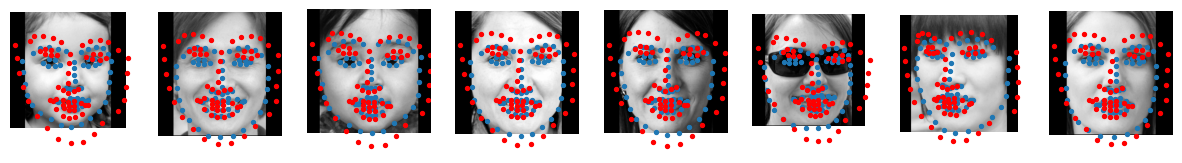

In [49]:
for (images, landmarks_trues, annotation_trues) in test_dataloader:
    _,_,_,outputs = loaded_model(images)
    landmarks_preds = outputs.detach().view(-1, 68, 2).squeeze()

    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

    for ax, image, landmarks, landmarks_pred in zip(axs, images, landmarks_trues, landmarks_preds):
        image_, landmarks_ = dataset.normalizer.denormalize(image, landmarks)
        image_, landmarks_pred_= dataset.normalizer.denormalize(image, landmarks_pred)

        if len(image_.numpy().squeeze().shape) == 2:
            ax.imshow(image_.numpy().squeeze(), cmap='gray')
        else:
            ax.imshow(image_)
        ax.scatter(landmarks_[:,0], landmarks_[:,1], s=8)
        ax.scatter(landmarks_pred_[:,0], landmarks_pred_[:,1], s=8, color="red")
        ax.axis("off")

    plt.show()

    break


## Metrics

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true, y_pred = [], []
max_batches = 2
for batch, tuple2unpack in enumerate(test_dataloader):
    images, landmarks_trues, annotation_true = tuple2unpack
    if max_batches == batch:
        break

    _,_,_,outputs = loaded_model(images)
    landmarks_preds = outputs.detach().view(-1, 68, 2).squeeze()


    for image, landmarks, landmarks_pred in zip(images, landmarks_trues, landmarks_preds):
        image_, landmarks_ = dataset.normalizer.denormalize(image, landmarks)
        image_, landmarks_pred_ = dataset.normalizer.denormalize(image, landmarks_pred)

        # Round the coordinates of the landmarks
        landmarks_ = np.round(landmarks_)
        landmarks_pred_ = np.round(landmarks_pred_)

        y_true.append(landmarks_.flatten())
        y_pred.append(landmarks_pred_.flatten())

y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)

# Flatten the matrices y_true y y_pred
y_true_flat = np.reshape(y_true, (-1, 2))
y_pred_flat = np.reshape(y_pred, (-1, 2))

# Compute the Mean Squared Error
mse = mean_squared_error(y_true_flat, y_pred_flat)
print("Mean Squared Error (MSE):", mse)

# Compute the Mean Absolute Error
mae = mean_absolute_error(y_true_flat, y_pred_flat)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 155.3888
Mean Absolute Error (MAE): 9.684742


## Test with any custom image

/home/aitor/miniconda3/envs/FaceLandmark/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


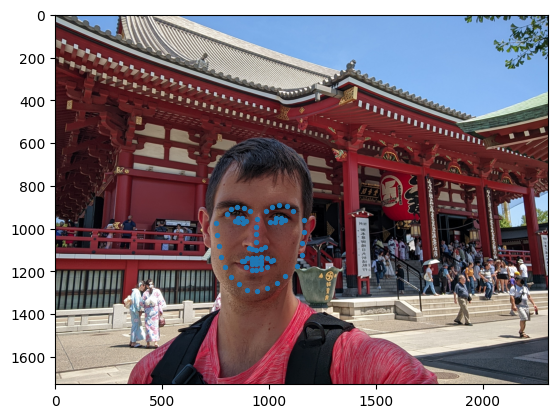

In [8]:
custom_image = convert_opencv_to_pillow(load_image_opencv_from_local("./IMG_20230724_124215169.MP.jpg"))
mtcnn_ = MTCNN(select_largest=False, post_process=False, keep_all=True, device=CONFIG.base.device)
x = []
y = []
detector = dlib.get_frontal_face_detector()
normalizer = Normalize(CONFIG.dataset.size)
gray = cv2.cvtColor(np.asarray(custom_image), cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)
for rect in rects:
    crop_frace = dict(
            left=rect.left(),
            top=rect.top(),
            width=rect.width(),
            height=rect.height()
        )
    face_gray_img, _ = Transforms.crop_face(Image.fromarray(gray), landmarks=None, crops=crop_frace)
    denormalizer = Normalize(face_gray_img.size)
    face_gray = np.asarray(face_gray_img.convert('L'))
    face_gray_, _ = normalizer(face_gray)
    _, _, _, landmarks = loaded_model(face_gray_.unsqueeze(0))
    landmarks = landmarks.detach().view(-1, 68, 2).squeeze()
    image, landmarks = denormalizer.denormalize(face_gray_, landmarks)

    for landmark in landmarks.numpy():
        x.append(landmark[0] + rect.left())
        y.append(landmark[1] + rect.top())

    if len(np.asarray(custom_image).squeeze().shape) == 2:
        plt.imshow(np.asarray(custom_image).squeeze(), cmap='gray')
    else:
        plt.imshow(np.asarray(custom_image))
        plt.scatter(x, y, s=8)
    plt.savefig("./Test_0.png")
    plt.show()
